## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations

Position is sensed, perturbed by Gaussian noise:

$$y_k = C z_k + r_k$$

where $r_k$ is measurement noise with covariance matrix $R$. 

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid C z_k, R) \, .
\end{align}$$

## Experiments

In [2]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using Revise
using Colors
using Optim
using MeshGrid
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, markersize=3, margin=15Plots.pt)

includet("../Robots.jl"); using. Robots
includet("../MARXAgents.jl"); using. MARXAgents
includet("../util.jl");

  Activating project at `c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-acquisition\narx-efe`


In [120]:
# Time
Δt = 0.1
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 1;

# Dimensionalities
Mu = 2
My = 2
Dy = 2
Du = Dy
Dx = My*Dy + Mu*Du
Dz = 4

# Setpoint (desired observation)
z_star = [0.0, 10., 0.0, 0.0]
goal = MvNormal(z_star[1:2], 0.5diagm(ones(2)))

# Parameters
σ = 1e-4*ones(Dy)
ρ = 1e-3*ones(Dy)

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Initial state
z_0 = [0.0, -10., 0., 0.]

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Prior parameters
ν0 = 10
Ω0 = 1e-1*diagm(ones(Dy))
Λ0 = 1e-2*diagm(ones(Dx))
M0 = 1e-8*randn(Dx,Dy)
Υ  = 1e-1*diagm(ones(Dy))

# Start agent
agent = MARXAgent(M0,Λ0,Ω0,ν0,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My)

MARXAgent(2, 8, 2, [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], 2, 2, [-7.182717574984204e-9 -4.611548908714912e-9; -6.179991632529852e-9 8.487135326195859e-9; … ; 8.77332594844915e-9 3.6216200401752836e-9; 8.985753428969514e-9 2.709139026797949e-9], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01], [0.1 0.0; 0.0 0.1], 10.0, [0.1 0.0; 0.0 0.1], FullNormal(
dim: 2
μ: [0.0, 10.0]
Σ: [0.5 0.0; 0.0 0.5]
)
, 1, 10, Inf)

### System identification

In [121]:
# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
u_sim   = zeros(Du,len_trial)
F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Fix controls
u_sim = randn(Du,len_trial)

# Fix starting state
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])

for k in 2:len_trial

    # Predictions
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    η,μ,Ψ = posterior_predictive(agent, x_k)
    preds_m[:,k] = μ
    preds_S[:,:,k] = inv(Ψ) * η/(η - 2)

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k])

    Ms[:,:,k] = agent.M
    Λs[:,:,k] = agent.Λ
    Ωs[:,:,k] = agent.Ω
    νs[k]     = agent.ν

    # Track free energy
    F_sim[k] = agent.free_energy
end

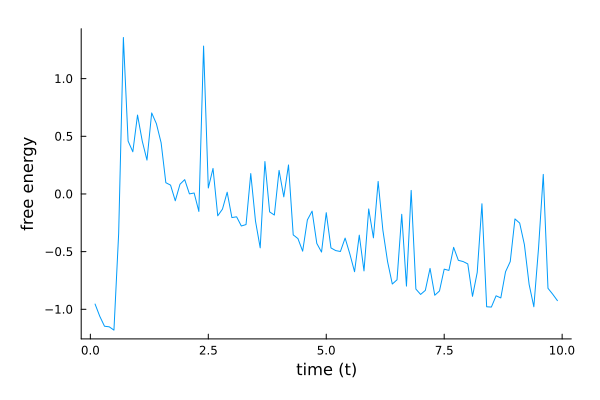

In [122]:
plot(tsteps[2:len_trial], F_sim[2:len_trial], xlabel="time (t)", ylabel="free energy")

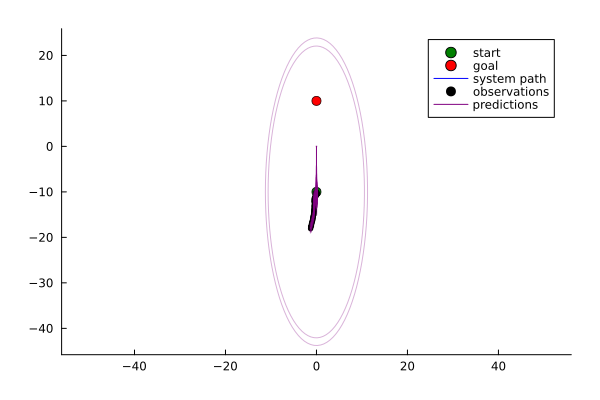

In [123]:
twin = 2:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")

plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, fillalpha=0.001, linecolor="purple", color="purple")
end
plot!(aspect_ratio=:equal)
# plot!(xlims=(-1,2), ylims=(-3,2))

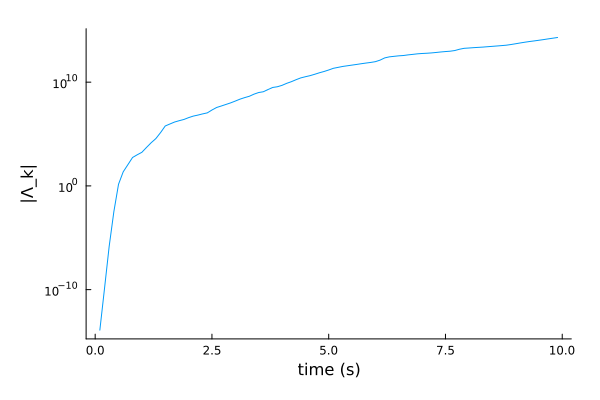

In [124]:
plot(tsteps[2:len_trial], [det(Λs[:,:,kk]) for kk in 2:len_trial], xlabel="time (s)", ylabel="|Λ_k|", yscale=:log10)

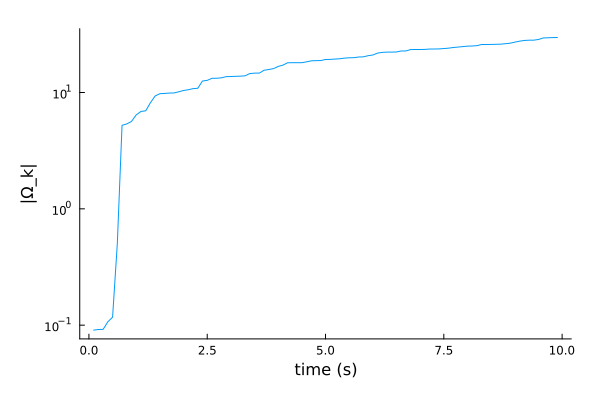

In [125]:
plot(tsteps[2:len_trial], [det(Ωs[:,:,kk]) for kk in 2:len_trial], xlabel="time (s)", ylabel="|Ω_k|", yscale=:log10)

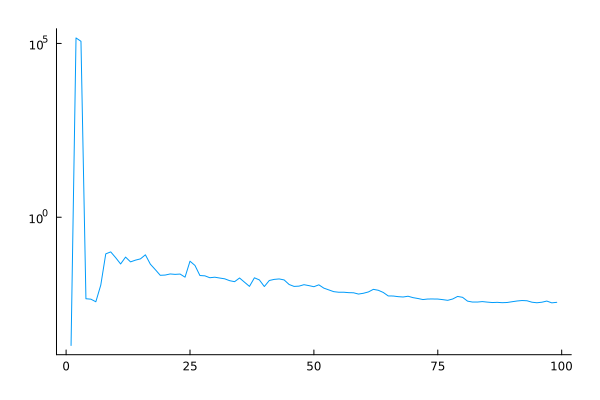

In [126]:
plot([det(preds_S[:,:,kk]) for kk in 2:len_trial], yscale=:log10)

In [127]:
[inv(agent.ν*inv(agent.Ω)) fbot.Q[1:2,1:2] fbot.R]

2×6 Matrix{Float64}:
  0.00272305   -0.000355889  3.33333e-8  0.0         0.001  0.0
 -0.000355889   0.91838      0.0         3.33333e-8  0.0    0.001

### Control

In [129]:
# Time
Δt = 0.1
len_trial = 3000
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 10;

In [ ]:
# Preallocate
y_pln  = (zeros(len_trial, Dy,len_horizon), zeros(len_trial, Dy,Dy,len_horizon))
z_sim  = zeros(Dz,len_trial)
y_sim  = zeros(Dy,len_trial)
u_sim  = zeros(Du,len_trial)
F_sim  = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

Nu = 31
ur = range(u_lims[1], stop=u_lims[2], length=Nu)
ux,uy = meshgrid(ur,ur)
uu = [ux[:]'; uy[:]']
Ju = zeros(Nu^2, len_trial)
CE = zeros(Nu^2, len_trial)
MI = zeros(Nu^2, len_trial)

# Initial state
z_sim[:,1] = z_0

@showprogress for k in 2:len_trial

    "Predict observation"
    
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    η,μ,Ψ = posterior_predictive(agent, x_k)
    preds_m[:,k] = μ
    preds_S[:,:,k] = inv(Ψ) * η/(η - 2)
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "Parameter estimation"

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k-1])

    Ms[:,:,k] = agent.M
    Λs[:,:,k] = agent.Λ
    Ωs[:,:,k] = agent.Ω
    νs[k]     = agent.ν

    # Track free energy
    F_sim[k] = agent.free_energy
    
    "Planning"
    
    # Visualize objective
    for ii in 1:Nu^2
      
        # Update control buffer
        ub = MARXAgents.backshift(agent.ubuffer, uu[:,ii])
        xx = [ub[:]; agent.ybuffer[:]]

        # Mutual info 
        MI[ii,k] = mutualinfo(agent, xx)
        CE[ii,k] = crossentropy(agent, xx)
        Ju[ii,k] = MI[ii,k] + CE[ii,k]

    end
    
    # Call minimizer using constrained L-BFGS procedure
    G(u::AbstractVector) = EFE(agent, u)
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(Du*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = Optim.minimizer(results)
    u_sim[:,k] = policy[1:Du]

    # # Planning under optimized policy
    planned_obs = predictions(agent, reshape(policy, (Du,len_horizon)), time_horizon=len_horizon)
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
end

Progress:   2%|█                                        |  ETA: 0:04:02

In [ ]:
twin = 10:len_trial
p1 = plot(tsteps[twin], u_sim[1,twin], label="u_1", ylims=u_lims)
p2 = plot(tsteps[twin], u_sim[2,twin], label="u_2", ylims=u_lims)
plot(p1,p2, layout=(2,1))

In [ ]:
twin = 10:len_trial
plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy")

In [ ]:
# twin = len_trial-1000:2:len_trial
twin = 10:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")

for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, alpha=0.001, fillalpha=0.0001, color="purple")
end
plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
# plot!(xlims=(-3,3), ylims=(-3,3))

In [ ]:
function trackbot(tk)

    xl = extrema(y_sim[1,:])
    yl = extrema(y_sim[2,:])
    ttime = round(tk*Δt, digits=1)
    plot(title="time = $ttime sec", xlims=xl, ylims=yl)

    scatter!([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
    scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
    covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
    scatter!([y_sim[1,tk]], [y_sim[2,tk]], alpha=0.3, label="observations", color="black")
    plot!([z_sim[1,tk]], [z_sim[2,tk]], marker=:star5, markersize=5, label="system path", color="blue")
   
    for kk = 1:len_horizon
        covellipse!(y_pln[1][tk,:,kk], y_pln[2][tk,:,:,kk]/100, linewidth=0, n_std=1, fillalpha=0.1, color="orange")
    end
    plot!(y_pln[1][tk,1,:], y_pln[1][tk,2,:], color="orange", label="planning")

end

anim = @animate for tt in 2:len_trial

    trackbot(tt)

end
gif(anim, fps=3/Δt)

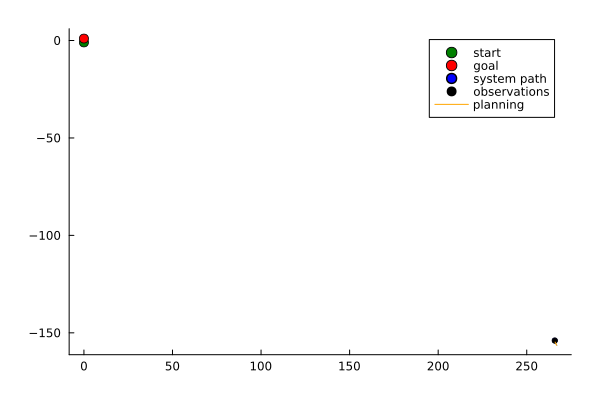

In [18]:
tk = len_trial-10 # > 1

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!([z_sim[1,tk]], [z_sim[2,tk]], label="system path", color="blue")
scatter!([y_sim[1,tk]], [y_sim[2,tk]], label="observations", color="black")

for kk = 1:len_horizon
    covellipse!(y_pln[1][tk,:,kk], y_pln[2][tk,:,:,kk]/100, n_std=1, fillalpha=0.1, color="orange")
end
plot!(y_pln[1][tk,1,:], y_pln[1][tk,2,:], color="orange", label="planning")

# plot!(xlims=(-2,2), ylims=(-2,2))
# plot!(xlims=(-10,10), ylims=(-10,10))

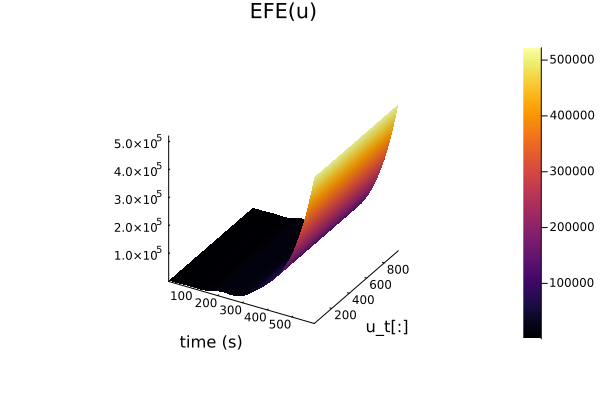

In [19]:
surface(Ju[:,10:len_trial], title="EFE(u)", xlabel="time (s)", ylabel="u_t[:]")

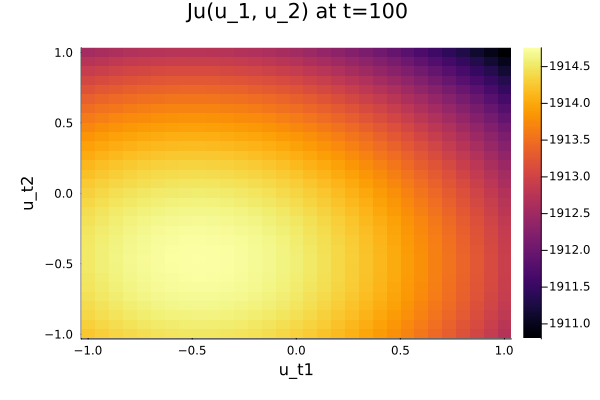

In [20]:
tk = 100
heatmap(ur, ur, reshape(Ju[:,tk], (Nu,Nu)), title="Ju(u_1, u_2) at t=$tk", xlabel="u_t1", ylabel="u_t2")

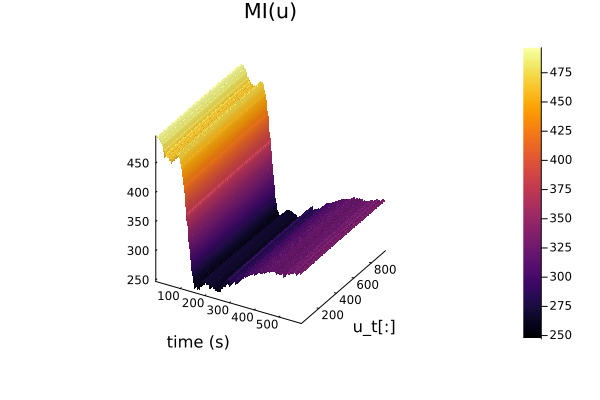

In [21]:
surface(MI[:,10:len_trial], title="MI(u)", xlabel="time (s)", ylabel="u_t[:]")

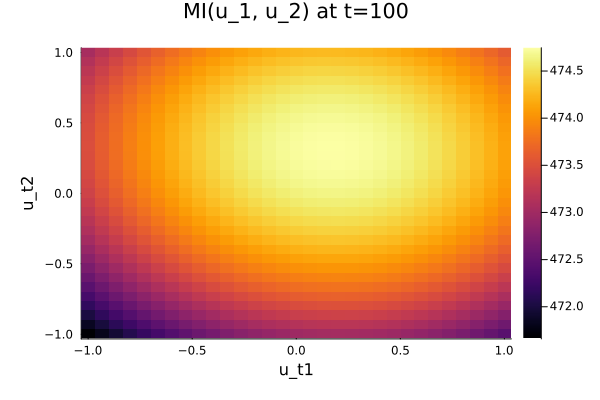

In [22]:
tk = 100
heatmap(ur, ur, reshape(MI[:,tk], (Nu,Nu)), title="MI(u_1, u_2) at t=$tk", xlabel="u_t1", ylabel="u_t2")

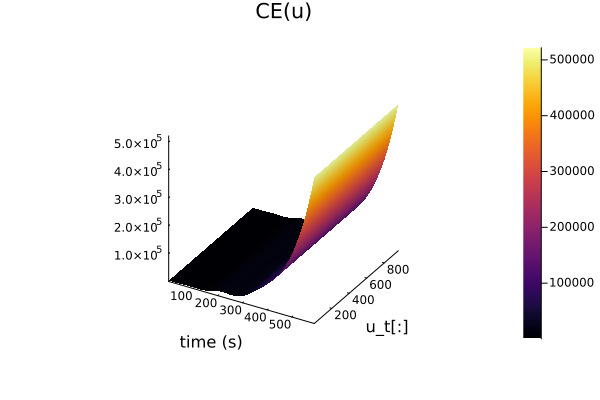

In [23]:
surface(CE[:,10:len_trial], title="CE(u)", xlabel="time (s)", ylabel="u_t[:]")

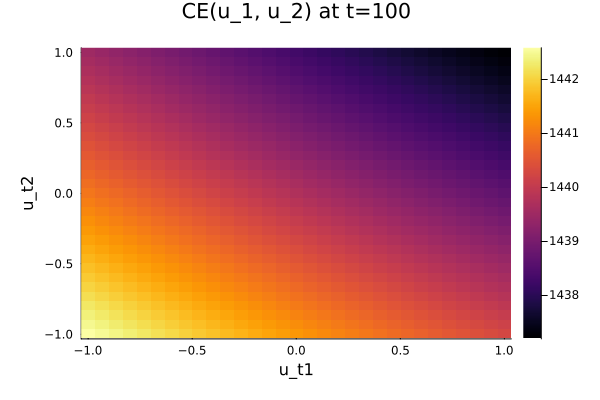

In [24]:
tk = 100
heatmap(ur, ur, reshape(CE[:,tk], (Nu,Nu)), title="CE(u_1, u_2) at t=$tk", xlabel="u_t1", ylabel="u_t2")

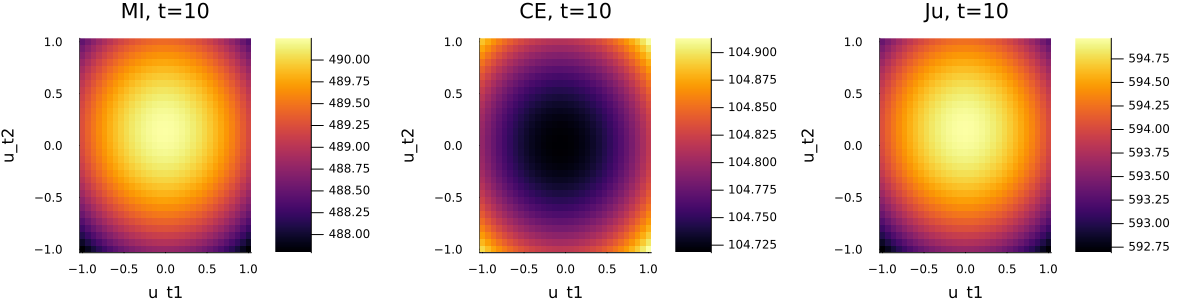

In [25]:
tk = 10

p31 = heatmap(ur, ur, reshape(MI[:,tk], (Nu,Nu)), title="MI, t=$tk", xlabel="u_t1", ylabel="u_t2")
p32 = heatmap(ur, ur, reshape(CE[:,tk], (Nu,Nu)), title="CE, t=$tk", xlabel="u_t1", ylabel="u_t2")
p33 = heatmap(ur, ur, reshape(Ju[:,tk], (Nu,Nu)), title="Ju, t=$tk", xlabel="u_t1", ylabel="u_t2")
plot(p31,p32,p33, layout=(1,3), size=(1200,300))